## Decision Trees
Decision trees can be very powerful machine learning tools.  One their biggest advantages is that they are easy to understand.  When given to employees, for example, they can illustrate policies through pictures.  Such an approach is much more memorable than using words.  Here is one example:

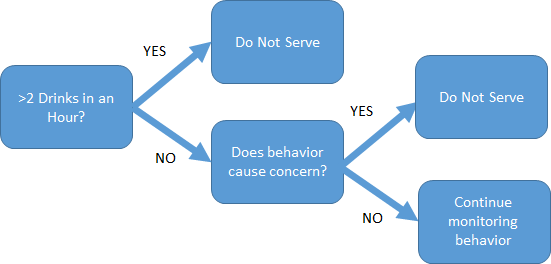

Compare the above to the following statement:
>*When serving a shift as a bartender, it is important to monitor your customers' behavior.  If a customer has more than 2 drinks in an hour, do not serve the customer.  If they have had fewer than 3 drinks, you need to monitor their behavior carefully.  If the customer is abusive, slurs his speech, or has trouble standing, you should not serve the customer.  If none of the above behaviors are present, it is still your responsibility to monitor the customers' behavior.  If any of the above behaviors are present, do not serve the customer.*

The above decision tree summarizes the policy in a succinct fashion.  It is also much more likely that the employee can process the conditionals (even in such an easy example).

Unlike previous algorithms, decision trees do categorization using a supervised learning approach.  We expose the decision tree to previous features and outcomes, and scikit attempts to categorize the outcome/target/dependent variable into desired categories.  The above tree categorizes customers into SERVE/DO NOT SERVE categories.

### Business Example: Customer Lending
Decision trees can be used to do more than illustrate a policy.  Within the realm of machine learning, they can also be used to understand--given a set of data--what policies the company is ACTUALLY following.  As an example within a bank, suppose the loan approval policy regarding a loan is the following:
* if the customer has a credit score >= 600
  * if the customers' savings is 25% or more of the requested loan, approve the loan
  * otherwise, reject the loan
* otherwise, 
  * if the customers' savings is 50% or more of the requested loan, approve the loan
  * otherwise, reject the loan

The company would obviously have the records of all loan applications, including the resulting decision on the loan.  Using sklearn and decision trees, therefore, it should be straightforward to determine if employees are following the official policy.

In [10]:
import pandas as pd
from sklearn import tree
df = pd.read_csv('loans.csv')

In [11]:
print(df.shape)
print(df.columns)

(5262, 5)
Index(['CreditScore', 'Savings', 'LoanRequested', 'City', 'Decision'], dtype='object')


### Swim in the Data


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CreditScore,5262.0,575.656024,159.102461,300.0,437.00,576.0,716.00,850.0
Savings,5262.0,49816.439567,20232.771793,-12680.0,36504.25,49641.0,63562.75,129715.0
LoanRequested,5262.0,299887.209806,99241.686013,571.0,232228.00,299836.0,369858.75,637847.0
Decision,5262.0,0.094641,0.292746,0.0,0.00,0.0,0.00,1.0


The decision column was coded as accepted = 1 and rejected = 0.  For that reason, the mean value for decision is the percentage of time the bank approved loans.  The 9.5% value seems very low. Are we just being tough?

### Feature Engineering
Because our policy considers the percentage of savings versus the loan amount, let's feature engineer a column that represents that amount:

In [13]:
df['percent'] = df.Savings / df.LoanRequested

Let's break down the descriptives by city:

In [14]:
df.groupby("City").describe().transpose()

City                        Newark     Wilmington
CreditScore   count    1296.000000    3966.000000
              mean      574.881173     575.909228
              std       159.529772     158.981910
              min       301.000000     300.000000
              25%       439.000000     436.000000
              50%       574.500000     577.500000
              75%       712.000000     716.000000
              max       849.000000     850.000000
Savings       count    1296.000000    3966.000000
              mean    49830.795525   49811.748361
              std     19755.601356   20388.729767
              min    -10702.000000  -12680.000000
              25%     37055.000000   36407.500000
              50%     49443.500000   49701.000000
              75%     63346.750000   63583.250000
              max    129715.000000  125653.000000
LoanRequested count    1296.000000    3966.000000
              mean   297010.883488  300827.128845
              std     96279.916552  100184.547869
              min       571.000000    1190.000000
              25%    231276.250000  232307.000000
              50%    297284.000000  300684.500000
              75%    368545.000000  371010.250000
              max    616668.000000  637847.000000
Decision      count    1296.000000    3966.000000
              mean        0.118056       0.086989
              std         0.322798       0.281855
              min         0.000000       0.000000
              25%         0.000000       0.000000
              50%         0.000000       0.000000
              75%         0.000000       0.000000
              max         1.000000       1.000000
percent       count    1296.000000    3966.000000
              mean        0.279494       0.225138
              std         2.828395       0.783011
              min        -0.030404      -0.068443
              25%         0.114866       0.114763
              50%         0.169165       0.166604
              75%         0.235918       0.235927
              max       101.793345      39.515126

The above analysis indicates that loans for people living in Wilmington are approved 8.7% of the time, but Newark loans are approved 11.8% of the time.  This doesn't necessarily mean bias, of course, because the people living in Wilmington may be less qualified than people living in Newark.  

If we look at the credit score, the values for the two cities are very close.  The saving values are almost identical. That seems to indicate that across the two cities, people have about the same qualififcations when they apply for a loan. HOWEVER, Newark residents have almost 28\% of savings versus the loan; Wilmington residents have only 22.5\% of the loan amount in savings.  Hmmmmmmmmm......the above analysis suggests digging in a little further.

One approach is to have sklearn (short for scikit-learn) generate a decision tree for the two cities.  We can then compare the two and see if the same criteria are being used to evaluate loans. 

Let's start by breaking up our data into X and Y dataframes, whic will be required for the decision tree.  

In [15]:
df.columns

Index(['CreditScore', 'Savings', 'LoanRequested', 'City', 'Decision',
       'percent'],
      dtype='object')

Let's start by creating a simple decision tree that includes only our credit score and the city.  This will allow us to determine if different city locations are using credit scores in a different way. Because the city is a text field (and we cannot use text fields directly), we have to create a binary variable that represents the two cities.  For our purposes, Newark will equal 0 and Wilmington will equal 1.

In [16]:
# Start by setting up the dependent variable (y)

y = df.Decision.copy() # y is the whether the loan was approved

# Create binary variable for City 
# CityCode = 0 if city is Newark
# CityCode = 1 if city is Wilmington
df["CityCode"] = 0 # sets entire column to 0
df.loc[df['City'] == 'Wilmington', 'CityCode'] = 1 # overwrites the value if Wilmington

X = df[['CreditScore', 'Savings', 'LoanRequested', 'percent', 'CityCode']]

In [17]:
X['CityCode'].value_counts()

1    3966
0    1296
Name: CityCode, dtype: int64

Now let's set up X so that it includes only the two features that we want:

In [18]:
X = X[['CreditScore', 'CityCode']]

In [19]:
y.value_counts()

0    4764
1     498
Name: Decision, dtype: int64

In [20]:
y.isnull().sum()

0

In [23]:
# Do a decision tree for all loans....let's see what the overall policy is as a baseline
loans = tree.DecisionTreeClassifier(max_depth=2, random_state = 0)
loans = loans.fit(X, y)

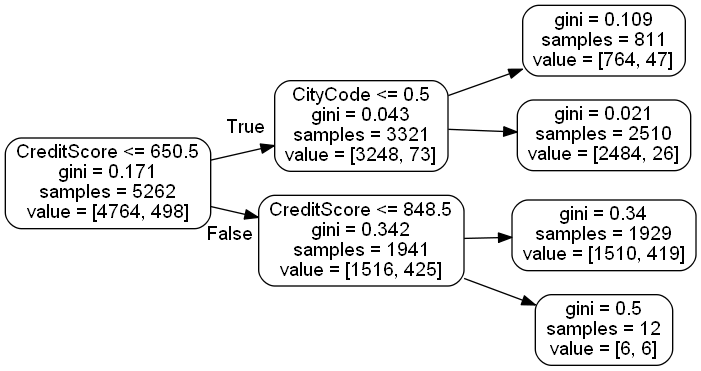

In [14]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(loans, out_file=dot_data,  
        feature_names=X.columns, rounded=True, rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())   

Examine the above tree **VERY CAREFULLY**! It is a very simple example of what we will be doing, so understanding it is critical.  Note that because there is a random element to decision trees, the numbers may differ in the following explanation. Let's assume we have a person with a credit score of 660 and lives in Newark.

Starting at the first node on the left side, the value in the node indicates [loan rejected, loan accepted].  Overall, therefore, 4764/(4764+498) (90.5%) of all customers were _rejected_.  Since the CreditScore <= 650 is True for our customer, then let's take the upper path.  

At this second stage, you can tell 3321 people had credit scores less than 650, and 1941 had scores above 650.  At the upper node, our person lives in Newark, so the condition CityCode <= 0.5 is True.  If we take the upper path again, we find that 764/(764+47) were rejected. That is 94.2\% of the people.

Now confirm the following:
* A person with a 600 credit score and lives in Wilmington has an almost 99\% chance of rejection
* A person with a 700 credit score has a 78.3\% chance of rejection, regardless of where he lives
* A person with a 850 credit score has a 50\% chance of acceptance, regardless of where he lives

The upper path then reflects the decisions for Newark (since CityCode = 0 for Newark).  Taking the upper path, note that the value is 1143 and 153.  For Newark, therefore, 153 out of 1296 loans were approved (1143 + 153 = 1296), or 11.8\%.  

If the CityCode is > 0.5, the city is Wilmington and the tree goes to the lower node. For Wilmington, 345 out of 3966 loans were approved (3621 + 345 = 3966) or 8.7\%. Note that 153+345 is 498, which is the value for the first node, and 1143 + 3621 = 4764.  This indicates:
* Of the 4764 loans that were rejected, 1143 were in Newark and 3621 were from Wilmington.
* Of the 498 loans that were approved, 153 were from Newark and 345 were from Wilmington.

# The Role of Gini
Gini is an entropy score of disparity, or difference.  If you have two groups of interest, the maximum amount of difference would be if you had 50\% of one type and 50\% of the other.  The gini coefficient would therefore be:
<br><br>`gini = 1 - [(0.50)**2 + (0.50)**2)] = 0.50`

In the first node of our tree, the gini calculation looks like this:
<br><br>`pct_declined = 4764/(498+4764)`
<br>`pct_approved = 498/(498+4764)`
<br>`gini = 1 - [pct_declined**2 + pct_approved**2]`
<br>`gini = 1 - [0.9054**2 + 0.0946**2]`
<br>`gini = 1 - [0.8197 + 0.009] = 0.171`

<br>You can see this is the value listed for gini in the first node.

## EXERCISE
* Within your team, do the calculation for the remaining two gini values. 
* Given the gini values, has entropy increased or decreased?
* Does city help us understand loan policies?  Why or why not?

In [7]:
X = df[['Savings', 'CreditScore']]
y = df.Decision.copy() # y is the whether the loan was approved

loans = tree.DecisionTreeClassifier(max_depth=2, random_state = 0)
loans = loans.fit(X, y)

//anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


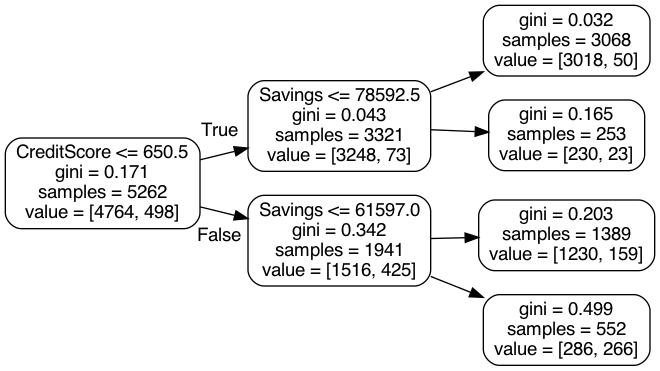

In [8]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(loans, out_file=dot_data,  
        feature_names=X.columns, rounded=True, rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())   

4764/4764 + 498 = 90.5%
Path1 : if credit score is than than or equal to 650.5, 3248/3248 + 73(97.8%) are rejected
if the saving amount is under 78k, then 3018/3068 = 98.4%

## Adding Other Factors to our Decision Tree
Since we have savings and the amount of loan requested, let's include those as features in our decision tree analysis.

In [15]:
X = df[['Savings', 'LoanRequested']]

# max_depth controls the size of the tree, after the initial node.  
# setting random state ensures you get the same answer as the one in this notebook
loans = tree.DecisionTreeClassifier(max_depth=2, random_state = 0)
loans = loans.fit(X, y)

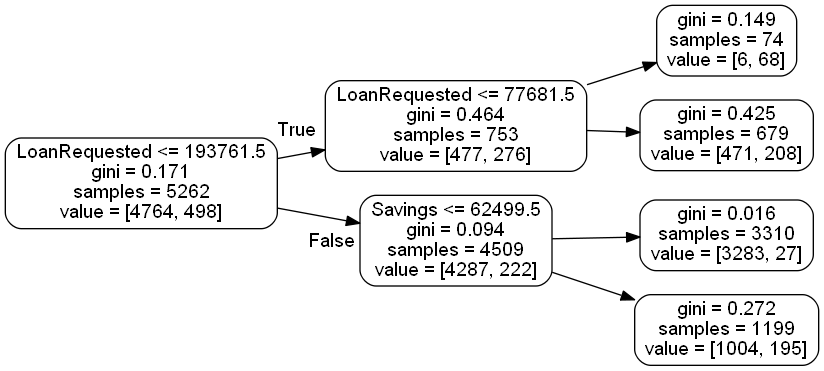

In [16]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
import pydotplus

dot_data = StringIO()  
tree.export_graphviz(loans, out_file=dot_data,  
        feature_names=X.columns, rounded=True, rotate=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())   

## Interpreting the Tree
Moving left to right, the tree indicates:
* Within each node, the criteria are listed first.  The gini value is the measure of entropy.  The samples indicate the number of customers at the point under consideration.  The value indicates [loan rejected, loan accepted].  Recall that overall, 4764/(4764+498) (90.5%) of all customers were _rejected_.  
* PATH 1: For loan amounts less than \$193761 (the upper branch), only 477/(477+276) (63\%) are rejected. Compare this to 90.5\% who were rejected overall.  Conclusion: smaller loan amounts increases your chances of getting the loan.
  * For customers who request less than \\$77K,  6/74 (8\%) are rejected.
  * For customers who request between \\$77K and \\$193K,  471/679 (69\%) are rejected.
* PATH 2: For loan amounts greater than \$193761 (the lower branch), 4287/4509 (95\%) are rejected. This indicates that asking for a lot of money means you have a higher chance of rejection.
    * For customers who have savings less than \\$62499.50 AND ask for a lot of money,  3283/3310 (95\%) are rejected. Conclusion: not having enough in savings also increases chances of rejection.
    * For customers who have savings greater than \$62499.50 AND ask for a lot of money,  1004/1199 (83\%) are rejected. 
  
If you examine the final gini values, the best categorization occurs when the loan amount is high (greater than 193K) and the customer has relatively low savings (gini = 0.016).  Apparently, rejecting the application under these circumstances is easy.  The toughest decision, however, occurs when the loan amount is lower than 193K and the credit score is > 650 (gini = 0.392).  

## Final Decision Tree
Your turn.  Explore a final decision tree, but consider the following:
* Does adding in the city and percent savings versus the loan amount help shed light on the categorization?  
* Perhaps it isnt the dollar amount of the loan, but the percentage of the laon versus the savings?  Create a new feature called *percent*, which represents the percent savings the person has, versus the loan.  Include that instead of the loan amount and the saving total.
* Remember that the decision tree algorithm seeks to minimize entropy.  That means it will choose the feature(s) that do the best job of reducing the gini score. Run the decision tree, but limit it to a max depth of 3.  Let's see what happens....

### REFLECTION
* As a group, consider four people that are represented by the features in your decision tree.  Walk through your tree, and determine the chances each has of getting a loan approved.  
* Be ready to verbally walk through the interpretation of the above decision tree.

